In [1]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [2]:
from torchvision.datasets import EMNIST
from torchvision.transforms import ToTensor

train_data = EMNIST(
    root = 'data',
    split = 'digits',
    train = True,
    download = True,
    transform = ToTensor())

test_data = EMNIST(
    root = 'data',
    split = 'digits',
    train = False,
    download = True,
    transform = ToTensor())

In [3]:
from torch.utils.data import DataLoader

batch_size = 2 ** 14
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [4]:
import numpy as np

x: np.ndarray
y: np.ndarray
for x, y in test_dataloader:
    print(f'shape of x [n, c, h, w]: {x.shape} {x.dtype}')
    print(f'shape of y: {y.shape} {y.dtype}')
    break

shape of x [n, c, h, w]: torch.Size([16384, 1, 28, 28]) torch.float32
shape of y: torch.Size([16384]) torch.int64


In [5]:
from torch import Tensor
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import LogSoftmax
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ReLU
from torch import flatten

class LigmaNetwork(Module):
    def __init__(self, in_size: int = 28):
        super(LigmaNetwork, self).__init__()

        win_size = in_size
        
        self.conv1 = Conv2d(in_channels = 1, out_channels = 32, padding = 1, kernel_size = 3, stride = 1)
        self.pool1 = MaxPool2d(kernel_size = 2, stride = 2)
        win_size //= 2
        
        self.conv2 = Conv2d(in_channels = 32, out_channels = 64, padding = 1, kernel_size = 3, stride = 1)
        self.pool2 = MaxPool2d(kernel_size = 2, stride = 2)
        win_size //= 2

        flat_size = win_size * win_size * self.conv2.out_channels
        self.dense1 = Linear(in_features = flat_size, out_features = 128)
        self.dense2 = Linear(in_features = 128, out_features = 10)
        
        self.relu = ReLU()
        self.log_prob = LogSoftmax(dim = 1)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        x = flatten(x, 1)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)

        return self.log_prob(x)

In [6]:
model = LigmaNetwork().to(device)
print(model)

LigmaNetwork(
  (relu): ReLU()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=3136, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=10, bias=True)
  (log_prob): LogSoftmax(dim=1)
)


In [7]:
from torch.nn import NLLLoss
from torch.optim import Adam

loss_fn = NLLLoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

In [8]:
from torch import Tensor
from tqdm import tqdm

max_epochs = 10
n_batch = len(train_dataloader)

i: int = 0
with tqdm(total = max_epochs * n_batch) as pbar:
    model.train()
    for epoch in range(max_epochs):
        x: Tensor
        y: Tensor
        y_pred: Tensor
        loss: Tensor
        for batch, (x, y) in enumerate(train_dataloader):
            i = pbar.n + 1
            
            # move data to gpu
            x, y = x.to(device), y.to(device)

            # compute prediction error
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update logs
            pbar.set_postfix({'i': i, 'epoch': epoch + 1, 'batch': batch + 1, 'loss': loss.item()})
            pbar.update()

100%|██████████| 150/150 [02:50<00:00,  1.14s/it, i=150, epoch=10, batch=15, loss=0.0647]


In [9]:
import torch

predicted_digits: int = []
actual_digits: int = []
with torch.no_grad():
    x: Tensor
    y: Tensor
    y_pred: Tensor
    loss: Tensor
    for batch, (x, y) in enumerate(test_dataloader):
        # move data to device
        x, y = x.to(device), y.to(device)

        # make the predictions and calculate the validation loss
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        # move data to cpu 
        predicted_digits += y_pred.argmax(1).detach().cpu().tolist()
        actual_digits += y.detach().cpu().tolist()

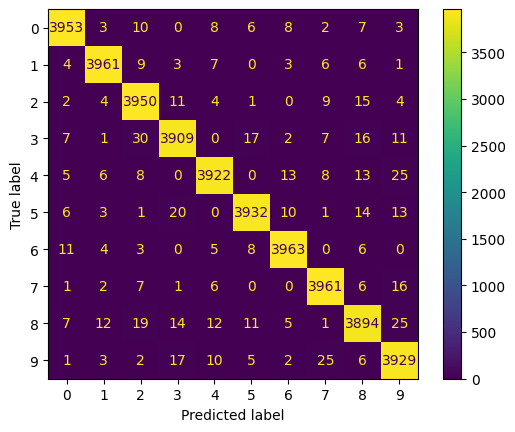

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(actual_digits, predicted_digits))
display.plot()